# Formula 1 - Modelling - Random Forest

### Import Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
import math

In [3]:
from collections import defaultdict
import regex as re
import datetime

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Perceptron, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import r2_score

import xgboost
from xgboost import XGBRegressor

import joblib

# Load The Data

In [5]:
driver_standings = pd.read_csv('./CSV/driver_standings.csv').drop(['Unnamed: 0'], axis=1)

In [6]:
constructor_standings = pd.read_csv('./CSV/constructor_standings.csv').drop(['Unnamed: 0'], axis=1)

In [7]:
main_df = pd.read_csv('./CSV/main_df.csv').drop(['Unnamed: 0'], axis=1)

In [8]:
main_df.head()

,season,round,race_name,name,constructor,grid,qual_position,q_best,q_worst,q_mean,...,circuitId,locality,country,type,direction,length,weather,finish_position,points,filled_splits
0,2014,1,australian,Nico Rosberg,mercedes,3.0,3.0,92.564,104.595,99.807667,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",1.0,25.0,0.000
1,2014,1,australian,Kevin Magnussen,mclaren,4.0,4.0,90.949,105.745,99.980333,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",2.0,18.0,26.777
2,2014,1,australian,Jenson Button,mclaren,10.0,11.0,91.396,104.437,97.916500,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",3.0,15.0,30.027
3,2014,1,australian,Fernando Alonso,ferrari,5.0,5.0,91.388,105.819,100.004000,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",4.0,12.0,35.284
4,2014,1,australian,Valtteri Bottas,williams,15.0,10.0,91.601,108.147,101.200000,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",5.0,10.0,47.639


In [9]:
# age variable committed to csv as datetime type, loaded as a string. Reformat to remove ' days' from instances.

def day_split(age):
    return int(age.split(' ')[0])

main_df.ageDuringRace = main_df.ageDuringRace.apply(day_split)

In [10]:
main_df.dtypes

season               int64
round                int64
race_name           object
name                object
constructor         object
grid               float64
qual_position      float64
q_best             float64
q_worst            float64
q_mean             float64
ageDuringRace        int64
circuitId           object
locality            object
country             object
type                object
direction           object
length             float64
weather             object
finish_position    float64
points             float64
filled_splits      float64
dtype: object

In [11]:
for col in main_df.columns:
    print('>>'+col)
    print(main_df[col].unique())

>>season
[2014 2015 2016 2017 2018 2019 2020 2021]
>>round
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
>>race_name
['australian' 'malaysian' 'bahrain' 'chinese' 'spanish' 'monaco'
 'canadian' 'austrian' 'british' 'german' 'hungarian' 'belgian' 'italian'
 'singapore' 'japanese' 'russian' 'us' 'brazilian' 'abu-dhabi' 'mexican'
 'european' 'azerbaijan' 'french' 'styrian' '70th-anniversary' 'tuscan'
 'eifel' 'portuguese' 'emilia-romagna' 'turkish' 'sakhir']
>>name
['Nico Rosberg' 'Kevin Magnussen' 'Jenson Button' 'Fernando Alonso'
 'Valtteri Bottas' 'Nico Hülkenberg' 'Kimi Räikkönen' 'Jean-Éric Vergne'
 'Daniil Kvyat' 'Sergio Pérez' 'Adrian Sutil' 'Esteban Gutiérrez'
 'Max Chilton' 'Jules Bianchi' 'Romain Grosjean' 'Marcus Ericsson'
 'Sebastian Vettel' 'Lewis Hamilton' 'Felipe Massa' 'Kamui Kobayashi'
 'Daniel Ricciardo' 'Pastor Maldonado' 'André Lotterer' 'Will Stevens'
 'Felipe Nasr' 'Carlos Sainz' 'Max Verstappen' 'Roberto Merhi'
 'Alexander Rossi' 'Jolyon Palmer' '

In [12]:
race_dps = []

for years in np.array(main_df.season.unique()):
    race_dps.extend([(years, race_name) if race_name != '70th-anniversary' 
                     else (race_name.split('-')[0], race_name.split('-')[1], years)
                     for race_name in 
                     list(main_df[main_df.season == years]['race_name'].unique())])
    race_dps.extend([(years, 'usa') for race_name in
                 list(main_df[main_df.season == years]['race_name'].unique()) if race_name=='us'])
    race_dps.extend([(years, 'mexico') for race_name in
                 list(main_df[main_df.season == years]['race_name'].unique()) if race_name=='mexican'])

# Modelling

### Train-Test Split on pre-2020 to predict 2020 onwards

In [73]:
# # Load a saved model

# pipe = joblib.load('ignore/models/f1model.pkl')
# model = joblib.load('ignore/models/f1model_XGB.pkl')
# model = joblib.load('ignore/models/f1model_RFR.pkl')

In [13]:
main = main_df.copy()

train = main[main.season<2020]
test = main[main.season==2020]

r_train = train.pop('finish_position')
y_train = train.pop('filled_splits')
p_train = train.pop('points')
X_train = train
r_test = test.pop('finish_position')
y_test = test.pop('filled_splits')
X_test = test
p_test = test.pop('points')

In [14]:
# Natural Language Processing
cvec_weather = CountVectorizer(stop_words='english', binary=True)#strip_words

# Dummification
ohe_direction = OneHotEncoder(handle_unknown='ignore')
ohe_country = OneHotEncoder(handle_unknown='ignore')
ohe_locality = OneHotEncoder(handle_unknown='ignore')
ohe_type = OneHotEncoder(handle_unknown='ignore')
ohe_season = OneHotEncoder(handle_unknown='ignore')
ohe_round = OneHotEncoder(handle_unknown='ignore')
ohe_qual_pos = OneHotEncoder(handle_unknown='ignore')
ohe_grid_pos = OneHotEncoder(handle_unknown='ignore')
ohe_racename = OneHotEncoder(handle_unknown='ignore')

# Standardisation
scaler_q_mean = StandardScaler(with_mean=False)
scaler_q_best = StandardScaler(with_mean=False)
scaler_q_worst = StandardScaler(with_mean=False)
scaler_length = StandardScaler(with_mean=False)
scaler_age = StandardScaler(with_mean=False)

In [15]:
col_trans = ColumnTransformer([
                               ('weather', cvec_weather, 'weather'),
                               ('direction', ohe_direction, ['direction']),
                               ('country', ohe_country, ['country']),
                               ('locality', ohe_locality, ['locality']),
                               ('type', ohe_type, ['type']),
                               ('season', ohe_season, ['season']),
                               ('round', ohe_round, ['round']),
                               ('qual_position', ohe_qual_pos, ['qual_position']),
                               ('grid', ohe_grid_pos, ['grid']),
                               ('race_name', ohe_racename, ['race_name']),
                               ('q_mean', scaler_q_mean, ['q_mean']),
                               ('q_best', scaler_q_best, ['q_best']),
                               ('q_worst', scaler_q_worst, ['q_worst']),
                               ('length', scaler_length, ['length']),
                               ('ageDuringRace', scaler_age, ['ageDuringRace'])
                              ], 
                             )

In [16]:
# weat = main_df.weather
# c = CountVectorizer(stop_words='english', binary=True).fit(weat)
# pd.DataFrame(c.transform(weat).toarray(), columns=c.vocabulary_)

In [17]:
# a selection of some of the different models run to be called on for testing.

lin = LinearRegression(fit_intercept=False)
# pol = PolynomialFeatures(degree=3)
dtr = DecisionTreeRegressor()
# knr = KNeighborsRegressor()
# rfr = RandomForestRegressor(n_estimators=10000, n_jobs=-2, verbose=1, criterion='mae', ccp_alpha=0.1)
# rfr = RandomForestRegressor(n_estimators=1000, n_jobs=-2, verbose=1, criterion='mse', ccp_alpha=0.04)
mlp = MLPRegressor(hidden_layer_sizes=(15, 10, 6, 3, 1), solver='adam', activation='relu', alpha=1, max_iter=50000, random_state=1)
pcp = Perceptron(tol=10**(-6), penalty='l1', alpha=0.001, n_jobs=-2, shuffle=True)
# rcv = RidgeCV(alphas=[0.1, 0.01, 0.05, 0.001], fit_intercept=True, cv=4)
# rid = Ridge(alpha=0.1, solver='auto', max_iter=1000)
las = Lasso(alpha=3.2, max_iter=3000, tol=5220460544.0)
# lcv = LassoCV(alphas=[0.1, 0.01, 0.05, 0.001], fit_intercept=True, cv=4)
# eln = ElasticNet()
# ecv = ElasticNetCV(l1_ratio=0.001, n_alphas=150, n_jobs=-2, alphas=[0.1, 0.05, 0.01])
bgr = BaggingRegressor(base_estimator=lin, n_estimators=10000, n_jobs=-2, verbose=2)
gbr = GradientBoostingRegressor(n_estimators=10000, learning_rate=0.001, init=las, max_depth=30, verbose=1)


rfr = RandomForestRegressor(ccp_alpha=0.08,
                            criterion='mse',
                            max_depth=None,
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            min_samples_leaf=1,
                            min_samples_split=2,
                            min_weight_fraction_leaf=0.0,
                            n_estimators=1000,
                            verbose=1)

xgb = XGBRegressor(gamma=0.1,
                   learning_rate=0.2,
                   max_depth=6,
                   n_estimators=150,
                   reg_alpha=None,
                   reg_lambda=0.2,
                   subsample=1,
                   verbosity=1)

In [18]:
# rfr.get_params()

In [19]:
# params = {'ccp_alpha': [0.03, 0.032, 0.034, 0.036, 0.038, 0.04, 0.042, 0.044, 0.046, 0.048, 0.05],
#           'criterion': ['mse'],
#           'max_depth': [2, 4, None],
#           'max_features': ['auto'],
#           'max_leaf_nodes': [None, 2, 3],
#           'max_samples': [None],
#           'min_impurity_decrease': [0.0],
#           'min_impurity_split': [None],
#           'min_samples_leaf': [1, 2],
#           'min_samples_split': [2, 3],
#           'min_weight_fraction_leaf': [0.0],
#           'n_estimators': [1000],
#           'n_jobs': [-2],
#           'oob_score': [False],
#           'random_state': [0],
#           'verbose': [1],
#           'warm_start': [False]}

In [20]:
# gs = GridSearchCV(rfr, params, verbose=1, n_jobs=-2, cv=5)

In [21]:
# a selection of some of the different models fitted to pipelines for easy call to testing.

# pipe = make_pipeline(col_trans, lin)
# pipe = make_pipeline(col_trans, las)
# pipe = make_pipeline(col_trans, gbr)
# pipe = make_pipeline(col_trans, bgr)
# pipe = make_pipeline(col_trans, mlp)
# pipe = make_pipeline(col_trans, knr)

# pipe = make_pipeline(col_trans, rfr)
pipe = make_pipeline(col_trans, xgb)
# pipe = make_pipeline(col_trans, model)

In [22]:
# pipe = make_pipeline(col_trans, gs)

All GridSearchCV & RandomizedSearchCV code has been warehoused in a separate file to increase presentability of this notebook. If you wish to see the code used, please don't hesitate to request the file.

In [23]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('weather',
                                                  CountVectorizer(binary=True,
                                                                  stop_words='english'),
                                                  'weather'),
                                                 ('direction',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['direction']),
                                                 ('country',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country']),
                                                 ('locality',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['locality']),
                    

In [24]:
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

0.9699502902670932
-0.23574395703922701


In [25]:
view_test = X_test.copy()
view_test['pred'] = pipe.predict(X_test)
view_test['true'] = y_test
view_test['true_finish_positions'] = r_test

test_indices = view_test.index

view_train = X_train.copy()
view_train['true'] = y_train
view_train['pred'] = pipe.predict(X_train)
view_train['true_finish_positions'] = r_train

train_indices = view_train.index

overall = pd.concat([view_test, view_train])
overall.sort_values(['season', 'round', 'pred'], inplace=True)




true_positions_test = []
indices_test = []
for race in race_dps:
    if race[1]=='anniversary':
        year = 2020
        circuit = '70th-anniversary'
    else:
        year = race[0]
        circuit = race[1]
    
    year_race = overall[(overall.season==year)&(overall.race_name==circuit)]

    def indexer(ind):
        return sorted(year_race.pred).index(ind)+1

    true_positions_test.extend(year_race.pred.apply(indexer))
    indices_test.extend(year_race.pred.apply(indexer).index)
positional_convert_test = pd.DataFrame(true_positions_test, index=indices_test).sort_index()
view_test['pred_positions'] = positional_convert_test




true_positions_train = []
indices_train = []
for race in race_dps:
    if race[1]=='anniversary':
        year = 2020
        circuit = '70th-anniversary'
    else:
        year = race[0]
        circuit = race[1]
    year_race = overall[(overall.season==year)&(overall.race_name==circuit)]

    def indexer(ind):
        return sorted(year_race.pred).index(ind)+1

    true_positions_train.extend(year_race.pred.apply(indexer))
    indices_train.extend(year_race.pred.apply(indexer).index)
positional_convert_train = pd.DataFrame(true_positions_train, index=indices_train).sort_index()
view_train['pred_positions'] = positional_convert_train




print(f'All Drivers Train Set R2 Score: {r2_score(view_train.true_finish_positions, view_train.pred_positions)}')
print(f'All Drivers Test Set R2 Score: {r2_score(view_test.true_finish_positions, view_test.pred_positions)}')




top_10_train = view_train[view_train.pred_positions<11]
print(f'Top 10 Finishers Test Set R2 Score: {r2_score(top_10_train.true_finish_positions, top_10_train.pred_positions)}')
top_10_test =  view_test[view_test.pred_positions<11]
print(f'Top 10 Finishers Test Set R2 Score: {r2_score(top_10_test.true_finish_positions, top_10_test.pred_positions)}')

All Drivers Train Set R2 Score: 0.5398956045767385
All Drivers Test Set R2 Score: 0.10512078782957857
Top 10 Finishers Test Set R2 Score: 0.40323125886012257
Top 10 Finishers Test Set R2 Score: -0.03740478129641178


In [26]:
top_10_test['match'] = top_10_test['true_finish_positions']==top_10_test['pred_positions']
top_10_test['match_+/-1'] = (top_10_test['true_finish_positions']-top_10_test['pred_positions'])**2<=1
top_10_test['match_+/-2'] = np.sqrt((top_10_test['true_finish_positions']-top_10_test['pred_positions'])**2)<=2
top_10_test['match_+/-3'] = np.sqrt((top_10_test['true_finish_positions']-top_10_test['pred_positions'])**2)<=3

<ipython-input-26-4eef6ee9c471>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_test['match'] = top_10_test['true_finish_positions']==top_10_test['pred_positions']
<ipython-input-26-4eef6ee9c471>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_test['match_+/-1'] = (top_10_test['true_finish_positions']-top_10_test['pred_positions'])**2<=1
<ipython-input-26-4eef6ee9c471>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [27]:
top_10_test['match'].value_counts(normalize=True)

False    0.835294
True     0.164706
Name: match, dtype: float64

In [28]:
top_10_test['match_+/-1'].value_counts(normalize=True)

False    0.641176
True     0.358824
Name: match_+/-1, dtype: float64

In [29]:
top_10_test['match_+/-2'].value_counts(normalize=True)

True     0.523529
False    0.476471
Name: match_+/-2, dtype: float64

In [30]:
top_10_test['match_+/-3'].value_counts(normalize=True)

True     0.641176
False    0.358824
Name: match_+/-3, dtype: float64

In [31]:
comparison_df = top_10_test.groupby('name')[['true_finish_positions', 'pred_positions']].agg(['sum','count'])

In [32]:
comparison_df.head()

true_finish_positions       pred_positions      
                                     sum count            sum count
name                                                               
Alexander Albon                     85.0    11             61    11
Antonio Giovinazzi                  10.0     1              7     1
Carlos Sainz                       129.0    13             90    13
Charles Leclerc                     60.0     8             38     8
Daniel Ricciardo                   103.0    15             97    15

In [33]:
comparison_df['true_average'] = comparison_df['true_finish_positions']['sum']/comparison_df['true_finish_positions']['count']
comparison_df['pred_average'] = comparison_df['pred_positions']['sum']/comparison_df['pred_positions']['count']

comparison_df.drop(['true_finish_positions', 'pred_positions'], axis=1).sort_values(['pred_average', 'true_average'])

,true_average,pred_average
,,
name,,
Lewis Hamilton,1.933333,1.600000
Valtteri Bottas,4.733333,2.400000
Max Verstappen,7.117647,3.647059
Sergio Pérez,7.400000,4.300000
Charles Leclerc,7.500000,4.750000
Alexander Albon,7.727273,5.545455
Lance Stroll,6.375000,6.000000
Lando Norris,7.538462,6.153846


In [34]:
# custom function for groupby

In [35]:
all_top_10 = pd.concat([top_10_train, top_10_test])
all_top_10 = all_top_10.sort_values(['season', 'round', 'pred_positions'])
all_top_10.reset_index(drop=True, inplace=True)
all_top_10 = all_top_10[['season', 'round', 'race_name', 'name', 'constructor', 'true_finish_positions', 'pred_positions']]
all_top_10.head(20)

,season,round,race_name,name,constructor,true_finish_positions,pred_positions
0,2014,1,australian,Nico Rosberg,mercedes,1.0,1
1,2014,1,australian,Daniel Ricciardo,red_bull,22.0,2
2,2014,1,australian,Kevin Magnussen,mclaren,2.0,3
3,2014,1,australian,Jenson Button,mclaren,3.0,4
4,2014,1,australian,Fernando Alonso,ferrari,4.0,5
5,2014,1,australian,Nico Hülkenberg,racing_point,6.0,6
6,2014,1,australian,Jean-Éric Vergne,alphatauri,8.0,7
7,2014,1,australian,Kimi Räikkönen,ferrari,7.0,8
8,2014,1,australian,Valtteri Bottas,williams,5.0,9
9,2014,1,australian,Daniil Kvyat,alphatauri,9.0,10


### Further Exploration of the Results

In [36]:
def points(pos):
    if pos==1: return 25
    if pos==2: return 18
    if pos==3: return 15
    if pos==4: return 12
    if pos==5: return 10
    if pos==6: return 8
    if pos==7: return 6
    if pos==8: return 4
    if pos==9: return 2
    if pos==10: return 1
    return 0

In [37]:
def constructor(name):
    return main_df[main_df.name==name][constructor]

In [38]:
view_test['points'] = view_test.pred_positions.apply(points)

In [39]:
view_test.head()

,season,round,race_name,name,constructor,grid,qual_position,q_best,q_worst,q_mean,...,country,type,direction,length,weather,pred,true,true_finish_positions,pred_positions,points
2432,2020,1,austrian,Valtteri Bottas,mercedes,1.0,1.0,62.939,64.111,63.355000,...,Austria,Race circuit,Clockwise,4.318,sunny dry 27.6°c,6.259337,0.000,1.0,3,15
2433,2020,1,austrian,Charles Leclerc,ferrari,7.0,7.0,63.923,64.500,64.154667,...,Austria,Race circuit,Clockwise,4.318,sunny dry 27.6°c,24.570490,2.700,2.0,7,6
2434,2020,1,austrian,Lando Norris,mclaren,3.0,4.0,63.626,64.606,64.017000,...,Austria,Race circuit,Clockwise,4.318,sunny dry 27.6°c,1.410158,5.491,3.0,1,25
2435,2020,1,austrian,Lewis Hamilton,mercedes,5.0,2.0,62.951,64.198,63.415000,...,Austria,Race circuit,Clockwise,4.318,sunny dry 27.6°c,22.637600,5.689,4.0,6,8
2436,2020,1,austrian,Carlos Sainz,mclaren,8.0,8.0,63.971,64.537,64.159667,...,Austria,Race circuit,Clockwise,4.318,sunny dry 27.6°c,21.815992,8.903,5.0,5,10


In [40]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

In [41]:
print(confusion_matrix(view_test.true_finish_positions, view_test.pred_positions))

[[8 2 2 2 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0]
 [2 5 5 2 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [3 4 2 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0]
 [0 2 0 1 4 2 2 1 2 0 1 0 1 0 0 0 0 0 1 0]
 [0 1 1 2 2 3 0 1 1 1 1 1 1 2 0 0 0 0 0 0]
 [0 0 1 1 1 2 2 3 0 0 1 1 0 2 2 1 0 0 0 0]
 [1 0 1 4 1 0 3 1 1 1 0 2 0 0 1 1 0 0 0 0]
 [0 1 1 1 0 2 1 2 0 1 0 0 1 3 0 1 1 0 1 1]
 [0 1 2 0 0 2 0 0 3 1 0 1 3 0 1 1 0 1 1 0]
 [1 0 0 1 0 0 2 1 3 0 1 1 1 2 1 0 1 1 0 1]
 [0 0 0 0 2 1 1 1 4 1 2 0 0 0 0 1 0 1 1 2]
 [0 0 0 0 1 0 3 1 0 1 1 1 0 0 3 1 0 3 1 1]
 [0 0 0 0 0 1 0 3 0 2 2 0 1 1 0 4 1 0 0 1]
 [0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 3 4 0 2 3]
 [0 0 1 0 0 1 0 1 1 1 1 1 2 1 0 1 2 1 1 2]
 [0 0 0 0 0 0 0 0 0 1 2 1 1 1 1 1 1 1 5 2]
 [0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 1 2 6 1 0]
 [0 0 0 0 2 0 0 0 1 1 0 1 1 1 3 0 3 1 0 3]
 [1 0 1 1 0 1 0 0 0 0 0 2 3 2 2 1 1 0 2 0]
 [1 1 0 0 1 0 0 1 0 2 2 3 0 0 2 0 1 2 1 0]]


In [42]:
np.diag(confusion_matrix(view_test.true_finish_positions, view_test.pred_positions)).sum()

38

What the figure above shows is the number of correctly predicted positions across the entire year.
40 positions equates to 2 of the 17 races correctly predicted (20 entrants per race for the 2020 season).

Alternatively, this can be summed up as a success race of 0.1176 or 11.76%.

In [43]:
print(classification_report(view_test.true_finish_positions, view_test.pred_positions))

              precision    recall  f1-score   support

         1.0       0.47      0.47      0.47        17
         2.0       0.29      0.29      0.29        17
         3.0       0.12      0.12      0.12        17
         4.0       0.06      0.06      0.06        17
         5.0       0.12      0.12      0.12        17
         6.0       0.12      0.12      0.12        17
         7.0       0.18      0.18      0.18        17
         8.0       0.12      0.12      0.12        17
         9.0       0.18      0.18      0.18        17
        10.0       0.00      0.00      0.00        17
        11.0       0.12      0.12      0.12        17
        12.0       0.06      0.06      0.06        17
        13.0       0.06      0.06      0.06        16
        14.0       0.00      0.00      0.00        17
        15.0       0.00      0.00      0.00        17
        16.0       0.06      0.06      0.06        17
        17.0       0.12      0.12      0.12        17
        18.0       0.06    

# Driver Standings

In [44]:
driver_points = view_test[['name', 'points']]
predicted_standings_driver = driver_points.groupby('name').agg('sum').sort_values(by='points', ascending=False)
predicted_standings_driver.reset_index(inplace=True)
predicted_standings_driver.head()

,name,points
0,Lewis Hamilton,330
1,Valtteri Bottas,269
2,Max Verstappen,230
3,Sergio Pérez,119
4,Daniel Ricciardo,114


In [45]:
def driver_id(name):
    name = name.split()[1].strip(' ').lower()
    if name == 'fittipaldi':
        return 'pietro_fittipaldi'
    elif name == 'räikkönen':
        return 'raikkonen'
    elif name == 'pérez':
        return 'perez'
    elif name == 'hülkenberg':
        return 'hulkenberg'
    elif name == 'magnussen':
        return 'kevin_magnussen'
    elif name == 'verstappen':
        return 'max_verstappen'
    else:
        return name

In [46]:
predicted_standings_driver['driverId'] = predicted_standings_driver.name.apply(driver_id)
predicted_standings_driver.drop(['name'], axis=1, inplace=True)
predicted_standings_driver = predicted_standings_driver.reindex(columns=['driverId', 'points'])

In [47]:
driver_comparison = driver_standings.drop(['position'], axis=1)
driver_comparison

,driverId,points
0,hamilton,347
1,bottas,223
2,max_verstappen,214
3,perez,125
4,ricciardo,119
5,sainz,105
6,albon,105
7,leclerc,98
8,norris,97
9,gasly,75


In [48]:
predicted_standings_driver

,driverId,points
0,hamilton,330
1,bottas,269
2,max_verstappen,230
3,perez,119
4,ricciardo,114
5,norris,109
6,albon,99
7,leclerc,92
8,sainz,82
9,stroll,68


In [49]:
driver_correlation_comparison = predicted_standings_driver.merge(driver_comparison, how='inner', on='driverId')
driver_correlation_comparison.columns=['driver', 'pred_points', 'true_points']
driver_correlation_comparison

,driver,pred_points,true_points
0,hamilton,330,347
1,bottas,269,223
2,max_verstappen,230,214
3,perez,119,125
4,ricciardo,114,119
5,norris,109,97
6,albon,99,105
7,leclerc,92,98
8,sainz,82,105
9,stroll,68,75


In [50]:
def pred_indexer(ind, df=driver_correlation_comparison):
    return sorted(df.pred_points, reverse=True).index(ind)+1
def true_indexer(ind, df=driver_correlation_comparison):
    return sorted(df.true_points, reverse=True).index(ind)+1

driver_correlation_comparison['pred_positions'] = driver_correlation_comparison.pred_points.apply(pred_indexer)
driver_correlation_comparison['true_positions'] = driver_correlation_comparison.true_points.apply(true_indexer)

In [51]:
driver_correlation_comparison['Pos Error (Diff: Pred - True)'] = driver_correlation_comparison.pred_positions - driver_correlation_comparison.true_positions

In [52]:
driver_correlation_comparison

,driver,pred_points,true_points,pred_positions,true_positions,Pos Error (Diff: Pred - True)
0,hamilton,330,347,1,1,0
1,bottas,269,223,2,2,0
2,max_verstappen,230,214,3,3,0
3,perez,119,125,4,4,0
4,ricciardo,114,119,5,5,0
5,norris,109,97,6,9,-3
6,albon,99,105,7,6,1
7,leclerc,92,98,8,8,0
8,sainz,82,105,9,6,3
9,stroll,68,75,10,10,0


In [53]:
driver_correlation_comparison['Pos Error (Diff: Pred - True)'].sum()

0

In [54]:
# true positive correct predictions

(driver_correlation_comparison.pred_positions == driver_correlation_comparison.true_positions).sum()

8

In [55]:
# driver_correlation_comparison.to_markdown

In [56]:
spearman_d = round(driver_correlation_comparison[['pred_points', 'true_points']].corr(method='spearman').iloc[0][1], 4)
pearson_d = round(driver_correlation_comparison[['pred_points', 'true_points']].corr(method='pearson').iloc[0][1], 4)
r2_d = round(r2_score(driver_correlation_comparison['true_points'], driver_correlation_comparison['pred_points']), 4)
mse_d = round(metrics.mean_squared_error(driver_correlation_comparison['true_points'], driver_correlation_comparison['pred_points']), 2)
rmse_d = round(np.sqrt(metrics.mean_squared_error(driver_correlation_comparison['true_points'], driver_correlation_comparison['pred_points'])), 3)

In [57]:
print(f'Spearman Rank Correlation: {spearman_d}')
print(f'Pearson Correlation:       {pearson_d}')
print(f'R2 Score:                  {r2_d}')
print(f'Mean Squared Error:        {mse_d}')
print(f'Root Mean Squared Error:   {rmse_d}')

Spearman Rank Correlation: 0.9705
Pearson Correlation:       0.9807
R2 Score:                  0.9601
Mean Squared Error:        300.74
Root Mean Squared Error:   17.342


In [58]:
# Spearman Rank Correlation: 0.9703
# Pearson Correlation:       0.9651
# R2 Score:                  0.925
# Mean Squared Error:        565.7
# Root Mean Squared Error:   23.784

Text(0, 0.5, 'True Points')

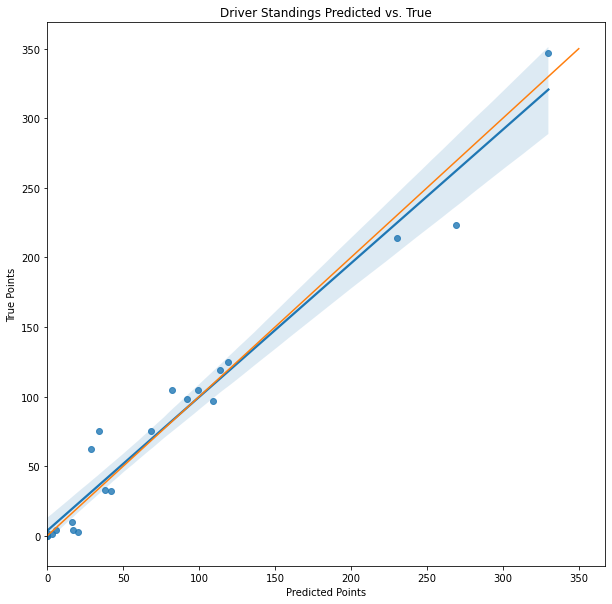

In [59]:
plt.subplots(figsize=(10, 10))
sns.regplot(data=driver_correlation_comparison, x='pred_points', y='true_points')
plt.plot([y_test.min(), 350], [y_test.min(), 350])
plt.title('Driver Standings Predicted vs. True')
plt.xlabel('Predicted Points')
plt.ylabel('True Points')

# Constructor Standings

In [60]:
constructor_points = view_test[['constructor', 'points']]

In [61]:
predicted_standings = constructor_points.groupby('constructor').agg('sum').sort_values(by='points', ascending=False)

In [62]:
predicted_standings.reset_index(inplace=True)

In [63]:
constructor_comparison = constructor_standings.drop(['position'], axis=1)

In [64]:
correlation_comparison = predicted_standings.merge(constructor_comparison, how='inner', on='constructor')
correlation_comparison.columns=['constructor', 'pred_points', 'true_points']
correlation_comparison

,constructor,pred_points,true_points
0,mercedes,617,573
1,red_bull,329,319
2,racing_point,203,195
3,mclaren,191,202
4,renault,143,181
5,ferrari,130,131
6,alphatauri,76,107
7,alfa,23,8
8,haas,3,3
9,williams,2,0


In [65]:
correlation_comparison['pred_positions'] = correlation_comparison.pred_points.apply(pred_indexer, df=correlation_comparison)
correlation_comparison['true_positions'] = correlation_comparison.true_points.apply(true_indexer, df=correlation_comparison)

In [66]:
correlation_comparison

,constructor,pred_points,true_points,pred_positions,true_positions
0,mercedes,617,573,1,1
1,red_bull,329,319,2,2
2,racing_point,203,195,3,4
3,mclaren,191,202,4,3
4,renault,143,181,5,5
5,ferrari,130,131,6,6
6,alphatauri,76,107,7,7
7,alfa,23,8,8,8
8,haas,3,3,9,9
9,williams,2,0,10,10


In [67]:
# true positive correct predictions

(correlation_comparison.pred_positions == correlation_comparison.true_positions).sum()

8

In [68]:
# correlation_comparison.to_markdown

In [69]:
spearman = round(correlation_comparison[['pred_points', 'true_points']].corr(method='spearman').iloc[0][1], 4)
pearson = round(correlation_comparison[['pred_points', 'true_points']].corr(method='pearson').iloc[0][1], 4)
r2 = round(r2_score(correlation_comparison['true_points'], correlation_comparison['pred_points']), 4)
mse = metrics.mean_squared_error(correlation_comparison['true_points'], correlation_comparison['pred_points'])
rmse = round(np.sqrt(metrics.mean_squared_error(correlation_comparison['true_points'], correlation_comparison['pred_points'])), 3)

In [70]:
print(f'Spearman Rank Correlation: {spearman}')
print(f'Pearson Correlation:       {pearson}')
print(f'R2 Score:                  {r2}')
print(f'Mean Squared Error:        {mse}')
print(f'Root Mean Squared Error:   {rmse}')

Spearman Rank Correlation: 0.9879
Pearson Correlation:       0.9941
R2 Score:                  0.9823
Mean Squared Error:        485.6
Root Mean Squared Error:   22.036


Text(0, 0.5, 'True Points')

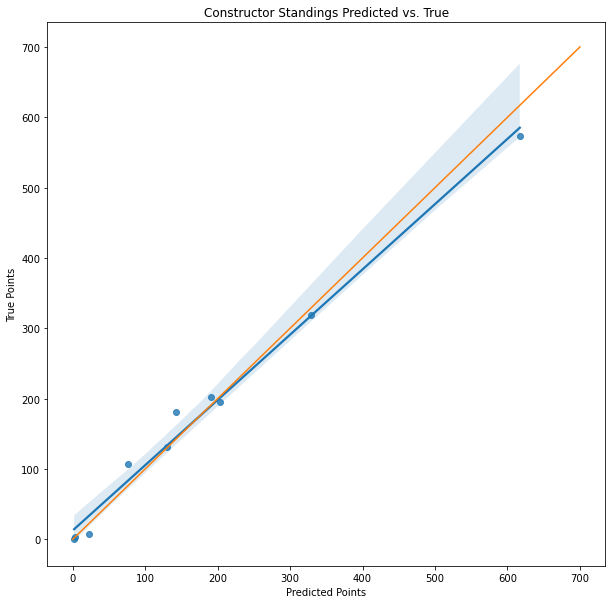

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.regplot(data=correlation_comparison, x='pred_points', y='true_points')
x_label=('Predicted Points')
plt.plot([y_test.min(), 700], [y_test.min(), 700])
plt.title('Constructor Standings Predicted vs. True')
plt.xlabel('Predicted Points')
plt.ylabel('True Points')

In [72]:
# # Save the model

# joblib.dump(pipe, 'ignore/models/f1model.pkl')